In [39]:
from bertopic import BERTopic
import pandas as pd
import pickle
import umap
import umap.plot
import hdbscan
import bokeh.plotting as bpl
import seaborn as sns
from bokeh.io import output_file, show, save
from plot import plot_bokeh
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_path='/media/marcin/Dane/model/'
# model_path='model/'

In [3]:
import psutil
psutil.virtual_memory()

svmem(total=16614080512, available=9276084224, percent=44.2, used=5424959488, free=5451010048, active=2138480640, inactive=7271477248, buffers=876797952, cached=4861313024, shared=1559724032, slab=340934656)

In [4]:
df = pd.read_csv('parsed/corpus/all.csv', index_col=0, na_filter=False)
docs = df[df.rok=="2015"].text.to_list()

In [5]:
df = df[df.rok=="2015"].copy()

In [6]:
topic_model = BERTopic.load(f'{model_path}2015-updated', embedding_model='xlm-r-distilroberta-base-paraphrase-v1')

with open(f'{model_path}topics.txt') as f:
    content = f.read()
    topics = eval(content)

topics_over_time = pd.read_csv(f'{model_path}topics_over_time.csv', index_col=0)

df['topic'] = topics

In [21]:
with open(f'{model_path}topics-2015-lexrank-top5-1.0.pkl', "rb") as fIn:
    topics = pickle.load(fIn)

df['topic'] = topics

In [11]:
with open(f'{model_path}embeddings-lexrank-weighted-2015.pkl', "rb") as fIn:
    embeddings_weighted = pickle.load(fIn)

In [12]:
with open(f'{model_path}embeddings-lexrank-min5-1.0-2015.pkl', "rb") as fIn:
    embeddings_top5 = pickle.load(fIn)

In [4]:
with open(f'{model_path}embeddings.pkl', "rb") as fIn:
    embeddings = pickle.load(fIn)

In [7]:
df['embedding'] = [x for x in embeddings]

In [42]:
iiirp = df[df.rok >= '1991']
lista1k = iiirp.lista.value_counts()[:22]
iiirp = iiirp[iiirp.lista.isin(lista1k.keys())]

In [71]:
vii_viii = df[df.rok >= '2011']
klub500 = vii_viii.klub.value_counts()[:5]
vii_viii = vii_viii[vii_viii.klub.isin(klub500.keys())]

In [64]:
klub500

Klub Parlamentarny Prawo i Sprawiedliwość                          29927
Klub Parlamentarny Platforma Obywatelska - Koalicja Obywatelska    17198
Klub Parlamentarny Platforma Obywatelska                           11185
Klub Poselski Sojusz Lewicy Demokratycznej                          6284
Klub Parlamentarny Polskiego Stronnictwa Ludowego                   4060
Klub Parlamentarny Polskie Stronnictwo Ludowe - Koalicja Polska     3369
Posłowie niezrzeszeni                                               2919
Klub Parlamentarny Zjednoczona Prawica                              2524
Klub Poselski Kukiz'15                                              2509
Koło Poselskie Ruch Palikota                                        1235
Koło Poselskie Konfederacja                                          563
Name: klub, dtype: int64

In [9]:
mapper = umap.UMAP(n_neighbors=15,
                        n_components=2,
                        min_dist=0.0,
                        metric='cosine').fit(embeddings)

<AxesSubplot:>

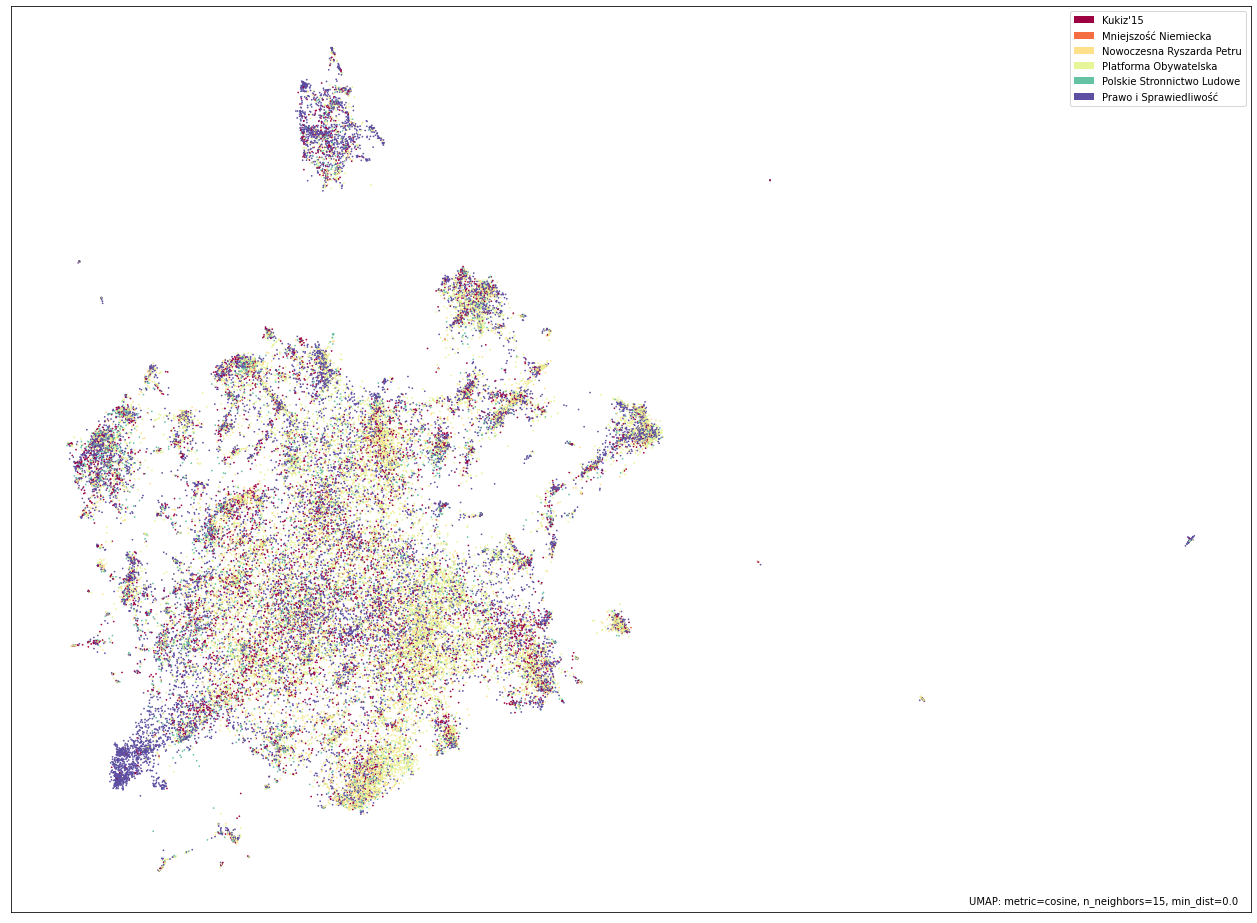

In [10]:
umap.plot.points(mapper, labels=df.lista, width=1600, height=1200, cmap="Spectral")

In [27]:
umap.plot.output_notebook()

Loading BokehJS ...

In [29]:
hover_data = df[['posel','topic']]
hover_data.reset_index(inplace=True)
alpha = [1 if x != -1 else 0.05 for x in df.topic]

In [15]:
p = plot_bokeh(umap_reduced.embedding_, labels=df.lista.to_list(), hover_data=hover_data, alpha=alpha, point_size=2, width=1200, height=1200)
# output_file("search-plot.html")
# save(p)
bpl.show(p)

'/home/marcin/mgr/search-plot.html'

/media/marcin/Dane/.miniconda3/envs/mgr-bertopic/lib/python3.8/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

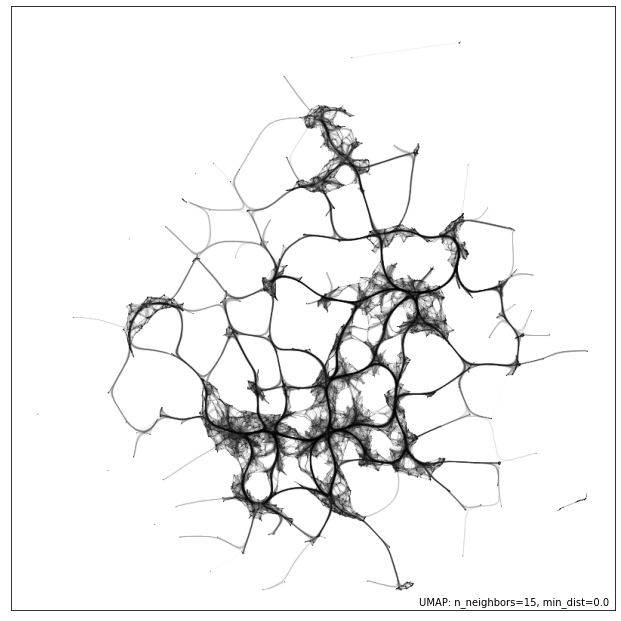

In [101]:
plot_hammer = umap.plot.connectivity(umap_reduced, edge_bundling='hammer')

# Combine

In [64]:
with open(f'{model_path}embeddings-lexrank-min5-1.0-2015.pkl', "rb") as fIn:
    embeddings_top5 = pickle.load(fIn)

In [6]:
with open(f'{model_path}embeddings-lexrank-weighted-2015.pkl', "rb") as fIn:
    embeddings_weighted = pickle.load(fIn)

In [49]:
with open(f'{model_path}embeddings-tfidf-2015.pkl', "rb") as fIn:
    embeddings_tfidf = pickle.load(fIn)

In [50]:
mapper_tfidf = umap.UMAP(n_neighbors=15,
                    n_components=5,
                    min_dist=0.0,
                    metric='hellinger').fit(embeddings_tfidf)

In [65]:
mapper_top5 = umap.UMAP(n_neighbors=15,
                    n_components=5,
                    min_dist=0.0,
                    metric='cosine').fit(embeddings_top5)

In [45]:
mapper_weighted = umap.UMAP(n_neighbors=15,
                    n_components=5,
                    min_dist=0.0,
                    metric='cosine').fit(embeddings_weighted)

In [15]:
intersection_mapper = mapper_top5 * mapper_weighted
union_mapper = mapper_top5 + mapper_weighted
contrast_mapper = mapper_top5 - mapper_weighted

In [38]:
inter_contr = mapper_top1 * contrast_mapper

In [66]:
mapper_combined = mapper_top5 * mapper_tfidf

In [39]:
# umap.plot.points(mapper_top5, labels=df.topic, width=1600, height=1200, cmap="Spectral")
p = plot_bokeh(inter_contr.embedding_, labels=df.topic.to_list(), hover_data=hover_data, alpha=alpha, point_size=1, width=1200, height=1200)
# output_file("search-plot.html")
# save(p)
bpl.show(p)

# HDBSCAN

In [72]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1).fit(mapper_combined_2d.embedding_)

In [73]:
df['topic'] = clusterer.labels_
df.topic.value_counts()

-1      11359
 21      1485
 128     1210
 14      1119
 136      993
        ...  
 60        51
 145       51
 186       51
 86        51
 116       50
Name: topic, Length: 190, dtype: int64

In [29]:
umap.plot.output_notebook()

Loading BokehJS ...

In [69]:
mapper_tfidf_2d = umap.UMAP(n_neighbors=15,
                    n_components=2,
                    min_dist=0.0,
                    metric='hellinger').fit(embeddings_tfidf)

mapper_top5_2d = umap.UMAP(n_neighbors=15,
                    n_components=2,
                    min_dist=0.0,
                    metric='cosine').fit(embeddings_top5)

mapper_combined_2d = mapper_top5_2d * mapper_tfidf_2d

In [74]:
alpha = [1 if x != -1 else 0.05 for x in df.topic]

In [75]:
p = plot_bokeh(mapper_combined_2d.embedding_, labels=clusterer.labels_, alpha=alpha, point_size=1, width=1200, height=1200)
# output_file("search-plot.html")
# save(p)
bpl.show(p)

<AxesSubplot:ylabel='Density'>

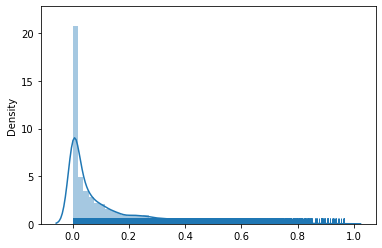

In [40]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)